In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm



matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import loadResults


In [2]:
EXPERIMENT_NAME = 'Experiment_template'

## Set configuration

In [2]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg
cfg.use_default_data = True
cfg.saved_index=30

## Obtain Data
Obtain the simulated $y$ and $f$

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(8192, 50) (1024, 50) (7168, 50)


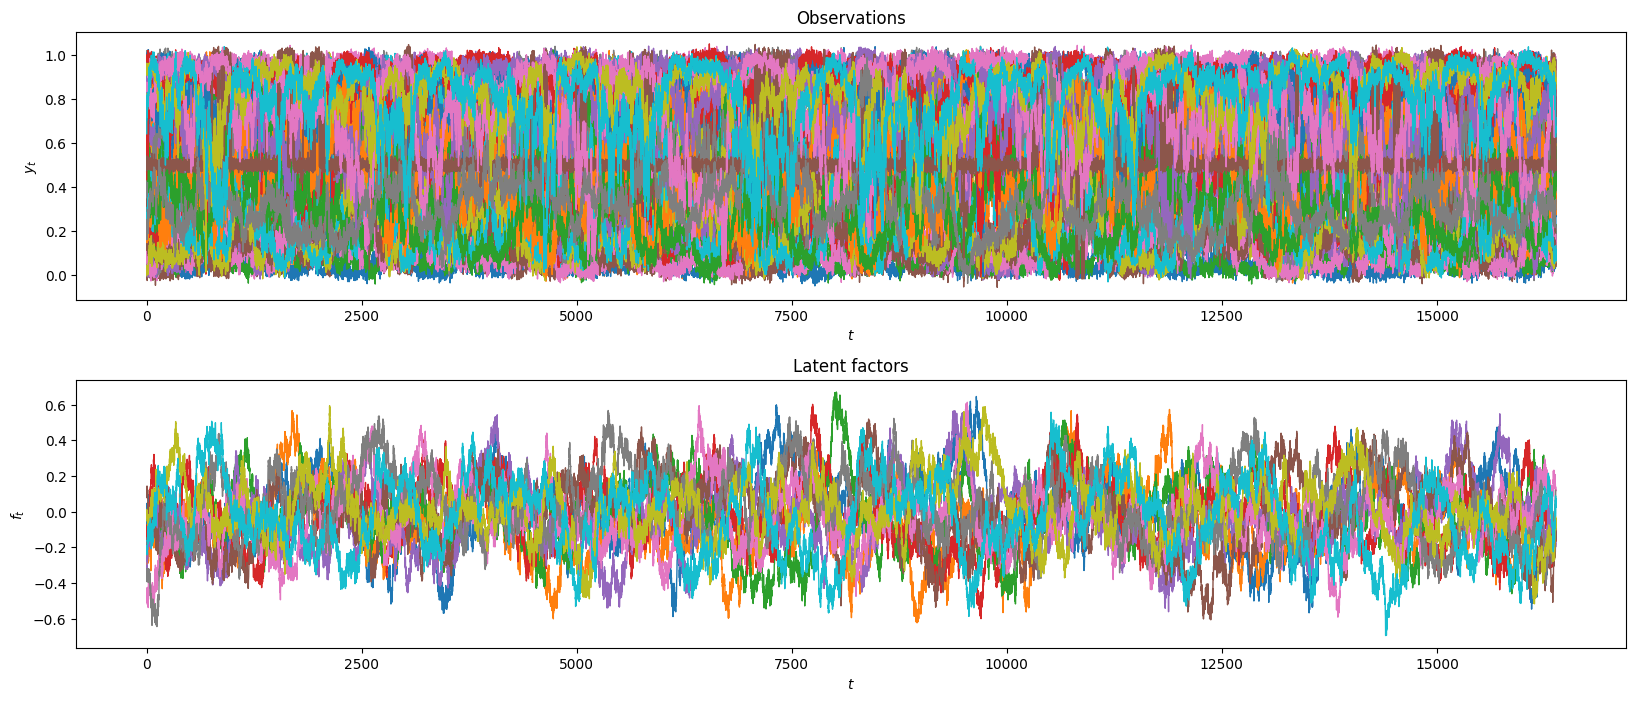

In [3]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim,5, 10,20,40,50,60,70,80,90, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True, use_xavier=True)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [5]:
from sklearn.decomposition import PCA
from evaluation import bootstrapCCA
mean = {}
ci = {}
bs_mean = {}
for T_train in [100,1000,10000]:
    f_train_ = f[0:T_train]
    #f_val_ = f[T_train:T_train+cfg.T_val]
    #f_test_ = f[T_train:]
    f_test_ = f[10000:]
    
    y_train_ = y[0:T_train]
    #y_val_ = y[T_train:T_train+cfg.T_val]
    #y_test_ = y[T_train:]
    y_test_ = y[10000:]

    #print(f_train_.shape)

    pca = PCA(n_components=cfg.factor_dim)
    f_train_hat = pca.fit_transform(y_train_)
    #f_val_hat = pca.transform(y_val_)
    cancorr = CanCorr(f_train_hat, f_train_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on train data: {cc}")

    f_test_hat = pca.transform(y_test_)
    y_test_hat = pca.inverse_transform(f_test_hat)
    cancorr = CanCorr(f_test_hat, f_test_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on test data: {cc}")
    mean[str(T_train)] = cc

    
    bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test_, n_bootstrap=100, n_sample=1000)
    #sns.distplot(bs)
    ci[str(T_train)]  = np.quantile(bs, [0.025, 0.975])
    bs_mean[str(T_train)] = np.mean(bs)

{'100': 0.71818381393123, '1000': 0.6772330762436474, '10000': 0.732719867992125}


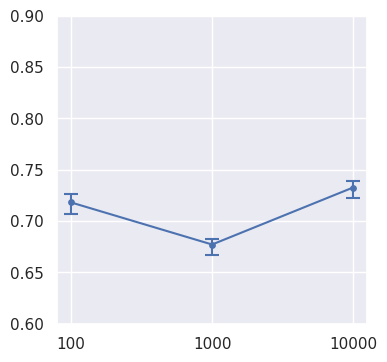

In [6]:
print(mean)
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.ylim(0.6,0.9)
for t, tci in ci.items():
    error = np.abs(tci-mean[t])
    plt.errorbar(x=t, y=mean[t],yerr=error[::-1][:,None], capsize=5, c='C0', capthick=1.5)
plt.scatter(x=mean.keys(),y=mean.values(), s=15, marker='o')
plt.plot(mean.keys(),mean.values())

In [15]:
ci

{'100': array([0.71275002, 0.7287541 ]),
 '1000': array([0.67027835, 0.68802412]),
 '10000': array([0.72688749, 0.74168939])}

In [8]:
models = {100:'4_OverParametrization_T100_05242023_13:54:31', 1000: '0_OverParametrization_T1000_05212023_15:04:07', 10000:'2_OverParametrization_T10000_05242023_13:20:21'}
mean_ae = {}
ci_ae = {}
bs_mean_ae = {}

for T_train, experimentName in models.items():
    train_hist, mod, cfg = loadResults(dgpIndex=30, name=experimentName)
    f_train_ = f[0:T_train]
    f_val_ = f[T_train:T_train+cfg.T_val]
    f_test_ = f[T_train+cfg.T_val:]

    y_train_ = y[0:T_train]
    y_val_ = y[T_train:T_train+cfg.T_val]
    y_test_ = y[T_train+cfg.T_val:]
    #print(f_train_.shape)

    f_train_hat = mod.enc(torch.Tensor(y_train_).float()).detach().numpy()
    f_val_hat =  mod.enc(torch.Tensor(y_val_).float()).detach().numpy()
    cancorr = CanCorr(f_train_hat, f_train_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on train data: {cc}")

    f_test_hat =  mod.enc(torch.Tensor(y_test_).float()).detach().numpy()
    y_test_hat =  mod(torch.Tensor(y_test_).float()).detach().numpy()
    mse = np.mean((y_test_hat-y_test_)**2)
    cancorr = CanCorr(f_test_hat, f_test_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on test data: {cc}")
    mean_ae[str(T_train)] = cc

    
    bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test_, n_bootstrap=500, n_sample=1000)
    #sns.distplot(bs)
    ci_ae[str(T_train)]  = np.quantile(bs, [0.025, 0.975])
    bs_mean_ae[str(T_train)] = np.mean(bs)

{'100': 0.5238306052951336, '1000': 0.7667062698100654, '10000': 0.8205252304891264}


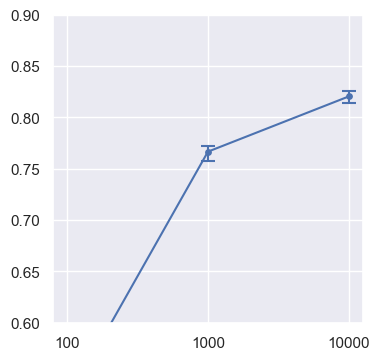

In [27]:
print(mean_ae)
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.ylim(0.6,0.9)
for t, tci in ci_ae.items():
    error = np.abs(tci-mean_ae[t])
    plt.errorbar(x=t, y=mean_ae[t],yerr=error[::-1][:,None], capsize=5, c='C0', capthick=1.5)
plt.scatter(x=mean_ae.keys(),y=mean_ae.values(), s=15, marker='o')
plt.plot(mean_ae.keys(),mean_ae.values())

In [7]:
models = {100:'13_assymetric_T100_06032023_23:47:02', 1000: '12_assymetric_T1000_06032023_23:19:46', 10000:'11_assymetric_T10000_06032023_22:28:10'}
mean_asym_ae = {}
ci_asym_ae = {}
bs_mean_asym_ae = {}

for T_train, experimentName in models.items():
    train_hist, mod, cfg = loadResults(dgpIndex=30, name=experimentName)
    f_train_ = f[0:T_train]
    f_val_ = f[T_train:T_train+cfg.T_val]
    f_test_ = f[T_train+cfg.T_val:]

    y_train_ = y[0:T_train]
    y_val_ = y[T_train:T_train+cfg.T_val]
    y_test_ = y[T_train+cfg.T_val:]
    #print(f_train_.shape)

    f_train_hat = mod.enc(torch.Tensor(y_train_).float()).detach().numpy()
    f_val_hat =  mod.enc(torch.Tensor(y_val_).float()).detach().numpy()
    cancorr = CanCorr(f_train_hat, f_train_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on train data: {cc}")

    f_test_hat =  mod.enc(torch.Tensor(y_test_).float()).detach().numpy()
    y_test_hat =  mod(torch.Tensor(y_test_).float()).detach().numpy()
    mse = np.mean((y_test_hat-y_test_)**2)
    cancorr = CanCorr(f_test_hat, f_test_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on test data: {cc}")
    mean_asym_ae[str(T_train)] = cc

    
    bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test_, n_bootstrap=500, n_sample=1000)
    #sns.distplot(bs)
    ci_asym_ae[str(T_train)]  = np.quantile(bs, [0.025, 0.975])
    bs_mean_asym_ae[str(T_train)] = np.mean(bs)

{'100': 0.5238306053407501, '1000': 0.7667062686661137, '10000': 0.8205252231591482}


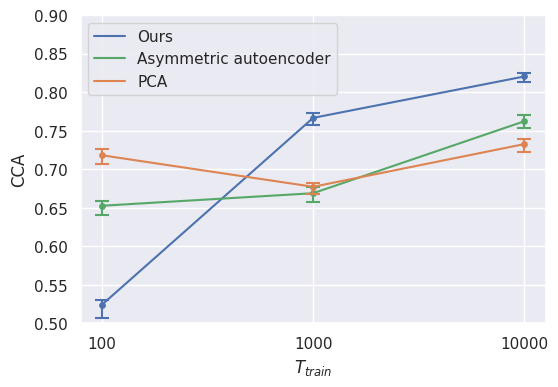

In [12]:
print(mean_ae)
import seaborn as sns
sns.set()
plt.figure(figsize=(6,4))
plt.ylim(0.5,0.9)
for t, tci in ci_ae.items():
    error = np.abs(tci-mean_ae[t])
    plt.errorbar(x=t, y=mean_ae[t],yerr=error[::-1][:,None], capsize=5, c='C0', capthick=1.5)#, elinewidth=10, alpha=0.5)
plt.scatter(x=mean_ae.keys(),y=mean_ae.values(), s=15, marker='o')
plt.plot(mean_ae.keys(),mean_ae.values(), label='Ours')

#asymmetric benchmark
for t, tci in ci_asym_ae.items():
    error = np.abs(tci-mean_asym_ae[t])
    plt.errorbar(x=t, y=mean_asym_ae[t],yerr=error[::-1][:,None], capsize=5, c='C2', capthick=1.5)#, elinewidth=10, alpha=0.5)
plt.scatter(x=mean_asym_ae.keys(),y=mean_asym_ae.values(), s=15, marker='o', c='C2')
plt.plot(mean_asym_ae.keys(),mean_asym_ae.values(), label='Asymmetric autoencoder', c='C2')

#add other values
for t, tci in ci.items():
    error = np.abs(tci-mean[t])
    plt.errorbar(x=t, y=mean[t],yerr=error[::-1][:,None], capsize=5, c='C1', capthick=1.5)#, alpha=0.5, elinewidth=10)
plt.scatter(x=mean.keys(),y=mean.values(), s=15, marker='o', c='C1')
plt.plot(mean.keys(),mean.values(), c= 'C1', label='PCA')

plt.xlabel('$T_{train}$')
plt.ylabel('CCA')
plt.legend(loc = 'upper left')


In [16]:
ci_ae

{'100': array([0.52692198, 0.53926525]),
 '1000': array([0.76708948, 0.7701189 ]),
 '10000': array([0.81946319, 0.82517379])}

In [18]:
bs_mean_ae

{'100': 0.5323763037650873,
 '1000': 0.7683375572941076,
 '10000': 0.8220381480694676}